In [51]:
import os
import numpy as np
from pathlib import Path
import pypianoroll as ppr
import pretty_midi
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt

## Import Data (phrase)

In [52]:
def checkDrumEmpty(track):
    compare = (track == np.zeros(track.shape))
    count = np.size(compare) - np.count_nonzero(compare)
    if count > 3:
        return True
    return False

In [53]:
DEFAULT_DRUM_TYPE_PITCHES = [
    # bass drum
    [36, 35],

    # snare drum
    [38, 27, 28, 31, 32, 33, 34, 37, 39, 40, 56, 65, 66, 75, 85],

    # closed hi-hat
    [42, 44, 54, 68, 69, 70, 71, 73, 78, 80],

    # open hi-hat
    [46, 67, 72, 74, 79, 81],

    # low tom
    [45, 29, 41, 61, 64, 84],

    # mid tom
    [48, 47, 60, 63, 77, 86, 87],

    # high tom
    [50, 30, 43, 62, 76, 83],

    # crash cymbal
    [49, 55, 57, 58],

    # ride cymbal
    [51, 52, 53, 59, 82]
]

In [54]:
_drum_map = dict(enumerate(DEFAULT_DRUM_TYPE_PITCHES))
_inverse_drum_map =  dict((pitch, index)
                                  for index, pitches in _drum_map.items()
                                  for pitch in pitches)

In [55]:
class MultiDrumOneHotEncoding():
    def __init__(self):
        self._drum_type_pitches = DEFAULT_DRUM_TYPE_PITCHES
        self._drum_map = dict(enumerate(DEFAULT_DRUM_TYPE_PITCHES))
        self._inverse_drum_map = dict((pitch, index) 
                                  for index, pitches in _drum_map.items()
                                  for pitch in pitches)

    def encode_drum(self, pitches_in):
        nonzero = np.where(pitches_in==1)[0] + 24
        ret = np.zeros(len(self._drum_type_pitches))
        for reduced, pitches in _drum_map.items():
            for p in pitches:
                if p in nonzero:
                    ret[reduced] = 1
                    break
        return ret
    
    def decode_drum(self, pitches_out):
        ret = np.zeros(84)
        for reduced, p in enumerate(pitches_out):
            if p == 1:
                ret[self._drum_type_pitches[reduced][0] - 24] = 1
        return ret
drum_encoding = MultiDrumOneHotEncoding()

In [56]:
PATH_HOME = str(Path.home())
PATH_TAGS = [
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Blues.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Country.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Electronic.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Folk.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Jazz.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Latin.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Metal.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_New-Age.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Pop.id', # 8
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Punk.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Rap.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Reggae.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_RnB.id',
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_Rock.id', # 13
    '/home/herman/lpd/id_lists/tagtraum/tagtraum_World.id',   
]
number_files = [19, 448, 352, 33, 127, 70, 112, 29, 1086, 12, 89, 53, 264, 1668, 10]
PATH_FILES = PATH_HOME + '/local_dir/salu133445/git/aicomposer/data/train_x.txt'
PATH = PATH_HOME + '/local_dir/salu133445/git/aicomposer/data/lpd_cleansed_stacked_pianoroll_11_tracks/'

In [58]:
# train_x_phr = np.zeros((0,96,9))
for tag_i, tag in enumerate(PATH_TAGS):
    train_x_phr = np.zeros((0,96,84))
    if tag_i == 2:
        print('>>' + tag[44:-3])
        with open(tag, 'r') as f:
            for i, file in enumerate(f):
                print('load files..{}/{}'.format(i + 1, number_files[tag_i]), end="\r")
                file = file.rstrip()
                middle = '/'.join(file[2:5]) + '/'
                p = PATH + middle + file
                for npz in os.listdir(p):
                    with np.load(p + '/' + npz) as data:
                        pianoroll = np.zeros(data['shape'], np.float32)
                        pianoroll[tuple(x for x in data['nonzero'])] = True
                        pianoroll = np.transpose(pianoroll, (0, 3, 1, 2))
                        pianoroll = pianoroll[:,0,:,:]
                        nz = np.nonzero(pianoroll)
                        if nz[2].size == 0:
                            break

#                         check = [ checkDrumEmpty(pianoroll) for i in range(pianoroll.shape[0])]
#                         p_cleaned = pianoroll[check]
#                         p_cleaned = pianoroll
                            
#                         p_reduced =  np.zeros((pianoroll.shape[0],96,9))
#                         for bar_i, bar in enumerate(p_reduced):
#                             # print ('converting...{}/{}'.format(bar_i + 1, p_cleaned.shape[0]), end="\r")
#                             for beat_i, beat in enumerate(bar):
#                                 p_reduced[bar_i][beat_i] = drum_encoding.encode_drum(beat)

#                         check = [ checkDrumEmpty(p_reduced) for i in range(p_reduced.shape[0])]
#                         p_cleaned_reduced = p_reduced[check]
#                         p_cleaned_reduced = p_reduced

                        train_x_phr = np.vstack((train_x_phr, pianoroll))
        print()
        print(train_x_phr.shape)
        if train_x_phr.shape[0] != 0:
            np.save('./data/all/train_x_drum_' + PATH_TAGS[tag_i][44:-3] + '.npy', train_x_phr)

>>Electronic
load files..352/352
(39212, 96, 84)


In [24]:
# np.save('./data/train_x_drum_reduced_' + PATH_TAGS[loading][44:-3] + '.npy', train_x_phr)

In [10]:
genre_i = 0
p_genre = './data/all/train_x_drum_' + PATH_TAGS[genre_i][44:-3] + '.npy'
train_x_phr_np = np.load(p_genre)

In [10]:
check = [ checkDrumEmpty(train_x_phr_np[i]) for i in range(train_x_phr_np.shape[0])]
train_x_drum_clean = train_x_phr_np[check]
print(train_x_drum_clean.shape)

train_x_drum_clean_reduced = np.zeros((
    train_x_drum_clean.shape[0],
    train_x_drum_clean.shape[1],
    len(DEFAULT_DRUM_TYPE_PITCHES),
))

for bar_i, bar in enumerate(train_x_drum_clean):
    print ('converting...{}/{}'.format(bar_i + 1, train_x_drum_clean.shape[0]), end="\r")
    for beat_i, beat in enumerate(bar):
        train_x_drum_clean_reduced[bar_i][beat_i] = drum_encoding.encode_drum(beat)

In [11]:
def pltDrumTrack(track, beat_resolution=96):
#     track = track.reshape((-1, 84))
    track = np.append(np.zeros((track.shape[0], 24)), track, axis=1)
    track = np.append(track, np.zeros((track.shape[0], 20)), axis=1)
    track = np.where(track == 1, 128, 0)
    track = Track(pianoroll=track)
    
    fig, axs = track.plot(
        xtick='beat',
        ytick='octave',
        yticklabel='number',
        beat_resolution=beat_resolution,
    )
    fig.set_size_inches(30,10)
    y = axs.set_ylim(34, 81) # C0 - C2
    plt.show()

In [12]:
def pltReducedDrumTrack(track, beat_resolution=12):
#     track = track.reshape((-1, 84))
#     track = np.append(np.zeros((track.shape[0], 24)), track, axis=1)
    track = np.append(track, np.zeros((track.shape[0], 119)), axis=1)
    track = np.where(track == 1, 128, 0)
    track = Track(pianoroll=track)
    
    fig, axs = track.plot(
        xtick='beat',
        yticklabel='number',
        beat_resolution=beat_resolution,
    )
    fig.set_size_inches(30,10)
    y = axs.set_ylim(0, 10) # C0 - C2
    y = axs.set_yticks(range(10))
    plt.show()

In [206]:
# print(len(train_x_phr))

# temp = []
# for phr in train_x_phr:
#     drum_track = np.transpose(phr[0], (2, 0, 1))[0]
#     if np.sum(drum_track) > 0:
#         temp.append(phr)

# print(len(temp))

In [14]:
# stack: list of ndarray -> ndarray

train_x_phr_np = np.vstack(train_x_phr)

In [15]:
print(train_x_phr_np.shape)
train_x_drum = train_x_phr_np

(163109, 96, 84)


## save/load the data to .npy

In [10]:
# np.save('./data/train_x.npy', train_x_phr_np)
# train_x_phr_np = np.load('./data/train_x.npy')

In [11]:
# train_x_phr_np.shape

In [12]:
# train_x_drum = np.transpose(train_x_phr_np, (0, 3, 1, 2))
# train_x_drum = train_x_drum[:,0,:,:]
# train_x_drum.shape

In [16]:
# check = [ checkDrumEmpty(train_x_drum[i]) for i in range(train_x_drum.shape[0])]
# train_x_drum_clean = train_x_drum[check]

In [273]:
# np.save('./data/train_x_drum.npy', train_x_drum_clean)
# train_x_drum_clean = np.load('./data/train_x_drum.npy')

In [17]:
train_x_drum_clean.shape

(139911, 96, 84)

## find the lowest note

In [42]:
print(train_x_phr.shape)
nz = np.nonzero(train_x_phr)
if nz[2].size > 0:
    print(nz[2].min())
    print(nz[2].max())
    print(nz[2])

(561, 96, 9)


In [43]:
for i in range(84):
    places = nz[0][np.where(nz[2] == i)]
    print('[{}]{}: {}'.format(
        i,
        pretty_midi.note_number_to_drum_name(i + 24),
        places.shape[0]))

[0]: 0
[1]: 0
[2]: 0
[3]: 0
[4]: 0
[5]: 0
[6]: 0
[7]: 0
[8]: 0
[9]: 0
[10]: 0
[11]Acoustic Bass Drum: 0
[12]Bass Drum 1: 0
[13]Side Stick: 0
[14]Acoustic Snare: 0
[15]Hand Clap: 0
[16]Electric Snare: 0
[17]Low Floor Tom: 0
[18]Closed Hi Hat: 0
[19]High Floor Tom: 0
[20]Pedal Hi Hat: 0
[21]Low Tom: 0
[22]Open Hi Hat: 0
[23]Low-Mid Tom: 0
[24]Hi-Mid Tom: 0
[25]Crash Cymbal 1: 0
[26]High Tom: 0
[27]Ride Cymbal 1: 0
[28]Chinese Cymbal: 0
[29]Ride Bell: 0
[30]Tambourine: 0
[31]Splash Cymbal: 0
[32]Cowbell: 0
[33]Crash Cymbal 2: 0
[34]Vibraslap: 0
[35]Ride Cymbal 2: 0
[36]Hi Bongo: 0
[37]Low Bongo: 0
[38]Mute Hi Conga: 0
[39]Open Hi Conga: 0
[40]Low Conga: 0
[41]High Timbale: 0
[42]Low Timbale: 0
[43]High Agogo: 0
[44]Low Agogo: 0
[45]Cabasa: 0
[46]Maracas: 0
[47]Short Whistle: 0
[48]Long Whistle: 0
[49]Short Guiro: 0
[50]Long Guiro: 0
[51]Claves: 0
[52]Hi Wood Block: 0
[53]Low Wood Block: 0
[54]Mute Cuica: 0
[55]Open Cuica: 0
[56]Mute Triangle: 0
[57]Open Triangle: 0
[58]: 0
[59]: 0
[60]: 0

## plot several examples

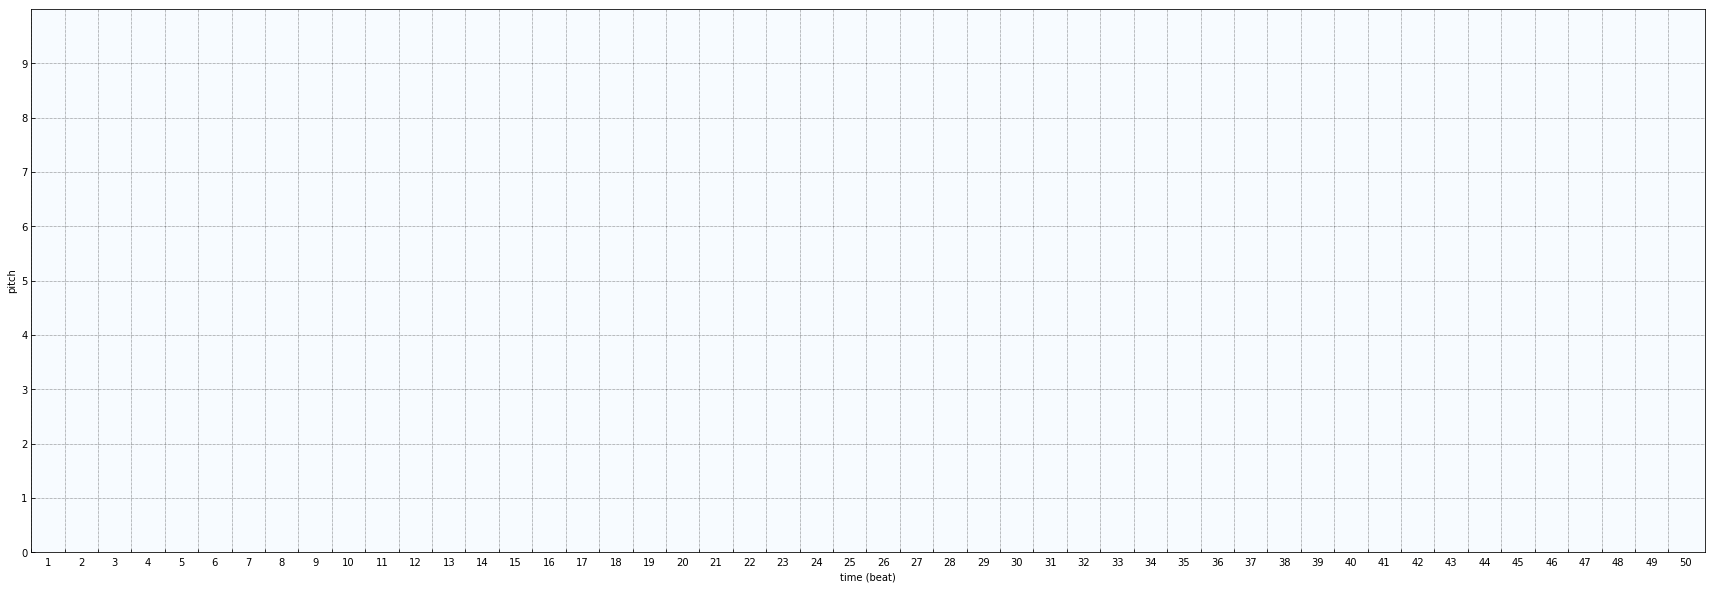

In [15]:
number = 1
offset = 0
length = 500
for i in range(number):
    tracks = train_x_phr[i*length+offset]
    for j in range(length):
        tracks = np.concatenate((tracks, train_x_phr[i*length+j+1+offset]), axis=0)
    pltReducedDrumTrack(tracks, 960)

## reduced drums: 9 classes

0. bass drum
1. snare drum
2. closed hi-hat
3. open hi-hat
4. low tom
5. mid tom
6. high tom
7. crash cymbal
8. ride cymbal

In [22]:
DEFAULT_DRUM_TYPE_PITCHES = [
    # bass drum
    [36, 35],

    # snare drum
    [38, 27, 28, 31, 32, 33, 34, 37, 39, 40, 56, 65, 66, 75, 85],

    # closed hi-hat
    [42, 44, 54, 68, 69, 70, 71, 73, 78, 80],

    # open hi-hat
    [46, 67, 72, 74, 79, 81],

    # low tom
    [45, 29, 41, 61, 64, 84],

    # mid tom
    [48, 47, 60, 63, 77, 86, 87],

    # high tom
    [50, 30, 43, 62, 76, 83],

    # crash cymbal
    [49, 55, 57, 58],

    # ride cymbal
    [51, 52, 53, 59, 82]
]

In [23]:
_drum_map = dict(enumerate(DEFAULT_DRUM_TYPE_PITCHES))
_inverse_drum_map =  dict((pitch, index)
                                  for index, pitches in _drum_map.items()
                                  for pitch in pitches)

In [24]:
class MultiDrumOneHotEncoding():
    def __init__(self):
        self._drum_type_pitches = DEFAULT_DRUM_TYPE_PITCHES
        self._drum_map = dict(enumerate(DEFAULT_DRUM_TYPE_PITCHES))
        self._inverse_drum_map = dict((pitch, index) 
                                  for index, pitches in _drum_map.items()
                                  for pitch in pitches)

    def encode_drum(self, pitches_in):
        nonzero = np.where(pitches_in==1)[0] + 24
        ret = np.zeros(len(self._drum_type_pitches))
        for reduced, pitches in _drum_map.items():
            for p in pitches:
                if p in nonzero:
                    ret[reduced] = 1
                    break
        return ret
    
    def decode_drum(self, pitches_out):
        ret = np.zeros(84)
        for reduced, p in enumerate(pitches_out):
            if p == 1:
                ret[self._drum_type_pitches[reduced][0] - 24] = 1
        return ret

In [25]:
drum_encoding = MultiDrumOneHotEncoding()
train_x_drum_clean_reduced = np.zeros((
    train_x_drum_clean.shape[0],
    train_x_drum_clean.shape[1],
    len(DEFAULT_DRUM_TYPE_PITCHES),
))

for bar_i, bar in enumerate(train_x_drum_clean):
    print ('converting...{}/{}'.format(bar_i + 1, train_x_drum_clean.shape[0]), end="\r")
    for beat_i, beat in enumerate(bar):
        train_x_drum_clean_reduced[bar_i][beat_i] = drum_encoding.encode_drum(beat)

KeyboardInterrupt: 

In [523]:
# np.save('./data/train_x_drum_reduced.npy', train_x_drum_clean_reduced)
train_x_drum_clean_reduced = np.load('./data/train_x_drum_reduced.npy')
print(train_x_drum_clean_reduced.shape)

(34452, 96, 9)


In [14]:
number = 1
offset = 0
length = 100
for i in range(number):
    tracks = train_x_drum_clean_reduced[i*length+offset]
    for j in range(length):
        tracks = np.concatenate((tracks, train_x_drum_clean_reduced[i*length+j+1+offset]), axis=0)
    pltReducedDrumTrack(tracks, 96)

NameError: name 'train_x_drum_clean_reduced' is not defined

In [516]:
nz = np.nonzero(train_x_drum_clean_reduced)
print(nz[2].min())
print(nz[2].max())
print(nz[2])

for i in range(9):
    places = nz[0][np.where(nz[2] == i)]
    print('[{}]{}: {}'.format(
        i,
        pretty_midi.note_number_to_drum_name(i + 24),
        places.shape[0]))

0
8
[2 2 3 ... 2 2 2]
[0]: 125101
[1]: 109414
[2]: 284301
[3]: 62846
[4]: 12464
[5]: 16865
[6]: 11591
[7]: 11464
[8]: 33799


In [452]:
train_x_drum_clean_reduced_recovered = np.zeros(
    train_x_drum_clean.shape)

for bar_i, bar in enumerate(train_x_drum_clean_reduced):
    print ('converting...{}/{}'.format(bar_i, train_x_drum_clean_reduced.shape[0]), end="\r")
    for beat_i, beat in enumerate(bar):
        train_x_drum_clean_reduced_recovered[bar_i][beat_i] = drum_encoding.decode_drum(beat)